In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa

import hylife.utilitis_FEEC.bsplines     as bsp
import hylife.utilitis_FEEC.Bspline      as bspline
import hylife.utilitis_FEEC.spline_space as spl

import hylife.utilitis_PIC_April2020.STRUPHY_fields       as pic_fields
import hylife.utilitis_PIC_April2020.STRUPHY_pusher       as pic_pusher
import hylife.utilitis_PIC_April2020.STRUPHY_accumulation as pic_accumu

import hylife.geometry.mappings_analytical as mapping
import hylife.interface as inter

# 1. Test field evaluation

## 1. 1 B-field

In [51]:
Nel       = [6, 8, 4]                 # mesh generation on logical domain
bc        = [False, False, False]     # boundary conditions (True: periodic, False: else)
p         = [3, 4, 2]                 # spline degrees 
nq_el     = [6, 6, 6]                 # number of quadrature points per element for integrations over whole domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)

# 1d B-spline finite element spaces
spaces = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)]

# 3d tensor-product B-spline spaces
tensor_space = spl.tensor_spline_space(spaces)


# number of basis functions in different spaces
NbaseN = tensor_space.NbaseN
NbaseD = tensor_space.NbaseD

Nbase_0form =  [NbaseN[0], NbaseN[1], NbaseN[2]]
Nbase_1form = [[NbaseD[0], NbaseN[1], NbaseN[2]], [NbaseN[0], NbaseD[1], NbaseN[2]], [NbaseN[0], NbaseN[1], NbaseD[2]]]
Nbase_2form = [[NbaseN[0], NbaseD[1], NbaseD[2]], [NbaseD[0], NbaseN[1], NbaseD[2]], [NbaseD[0], NbaseD[1], NbaseN[2]]]
Nbase_3form =  [NbaseD[0], NbaseD[1], NbaseD[2]]

Ntot_0form  =  NbaseN[0]*NbaseN[1]*NbaseN[2] 
Ntot_1form  = [NbaseD[0]*NbaseN[1]*NbaseN[2], NbaseN[0]*NbaseD[1]*NbaseN[2], NbaseN[0]*NbaseN[1]*NbaseD[2]]
Ntot_2form  = [NbaseN[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseD[1]*NbaseN[2]]  
Ntot_3form  =  NbaseD[0]*NbaseD[1]*NbaseD[2]


N = [bspline.Bspline(T, p)     for T, p in zip(T, p)]
D = [bspline.Bspline(t, p - 1) for t, p in zip(t, p)]

# geometry
kind_map   = 3
#params_map = [1., 1., 1.]
params_map = [2., 3., 0.01, 5.]


# ==== coefficients for pp-forms in interval [0, delta] (N and D) for fast field evaluation
pp0 = []
pp1 = []

delta = tensor_space.delta 

for i in range(3):
    
    if   p[i] == 1:
        pp0.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]]))
        pp1.append(np.asfortranarray([[1/delta[i]]]))
    
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    
    elif p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    
    elif p[i] == 4:
        pp0.append(np.asfortranarray([[1/24, -1/(6*delta[i]), 1/(4*delta[i]**2), -1/(6*delta[i]**3), 1/(24*delta[i]**4)], [11/24, -1/(2*delta[i]), -1/(4*delta[i]**2), 1/(2*delta[i]**3), -1/(6*delta[i]**4)], [11/24, 1/(2*delta[i]), -1/(4*delta[i]**2), -1/(2*delta[i]**3), 1/(4*delta[i]**4)], [1/24, 1/(6*delta[i]), 1/(4*delta[i]**2), 1/(6*delta[i]**3), -1/(6*delta[i]**4)], [0., 0., 0., 0., 1/(24*delta[i]**4)]]))
        pp1.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]])/delta[i])
    
    else:
        print('Spline degree > 4 not yet implemented!')
# ======================================================================


b1 = np.zeros((NbaseN[0], NbaseD[1], NbaseD[2]), order='F')
b2 = np.zeros((NbaseD[0], NbaseN[1], NbaseD[2]), order='F')
b3 = np.zeros((NbaseD[0], NbaseD[1], NbaseN[2]), order='F')

b1[:, :, :] = 0.1*(np.random.rand(NbaseN[0], NbaseD[1], NbaseD[2]) - 0.5)
b2[:, :, :] = 0.1*(np.random.rand(NbaseD[0], NbaseN[1], NbaseD[2]) - 0.5)
b3[:, :, :] = 0.1*(np.random.rand(NbaseD[0], NbaseD[1], NbaseN[2]) - 0.5)

Np        = int(20)
particles = np.asfortranarray(np.random.rand(Np, 7))

In [52]:
B = np.empty((Np, 3), order='F')

for ip in range(Np):
    
    print(ip)
    
    B[ip, 0] = inter.b1_eq(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map)
    B[ip, 1] = inter.b2_eq(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map)
    B[ip, 2] = inter.b3_eq(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map)
    
    # evaluation of B1 - component (NDD)
    for i1 in range(NbaseN[0] + bc[0]*p[0]):
        for i2 in range(NbaseD[1] + bc[1]*(p[1] - 1)):
            for i3 in range(NbaseD[2] + bc[2]*(p[2] - 1)):

                N1 = N[0](particles[ip, 0], i1)
                D2 = D[1](particles[ip, 1], i2)*p[1]/(t[1][i2 + p[1]] - t[1][i2])
                D3 = D[2](particles[ip, 2], i3)*p[2]/(t[2][i3 + p[2]] - t[2][i3])

                B[ip, 0] += b1[i1%NbaseN[0], i2%NbaseD[1], i3%NbaseD[2]] * N1 * D2 * D3
                
    # evaluation of B2 - component (DND)
    for i1 in range(NbaseD[0] + bc[0]*(p[0] - 1)):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseD[2] + bc[2]*(p[2] - 1)):

                D1 = D[0](particles[ip, 0], i1)*p[0]/(t[0][i1 + p[0]] - t[0][i1])
                N2 = N[1](particles[ip, 1], i2)
                D3 = D[2](particles[ip, 2], i3)*p[2]/(t[2][i3 + p[2]] - t[2][i3])

                B[ip, 1] += b2[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseD[2]] * D1 * N2 * D3
                
    # evaluation of B3 - component (DDN)
    for i1 in range(NbaseD[0] + bc[0]*(p[0] - 1)):
        for i2 in range(NbaseD[1] + bc[1]*(p[1] - 1)):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):

                D1 = D[0](particles[ip, 0], i1)*p[0]/(t[0][i1 + p[0]] - t[0][i1])
                D2 = D[1](particles[ip, 1], i2)*p[1]/(t[1][i2 + p[1]] - t[1][i2])
                N3 = N[2](particles[ip, 2], i3)

                B[ip, 2] += b3[i1%NbaseD[0], i2%NbaseD[1], i3%NbaseN[2]] * D1 * D2 * N3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [53]:
B_part = np.empty((Np, 3), dtype=float, order='F')
pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)

In [54]:
np.allclose(B_part, B)

True

## 1. 2 U-field

In [58]:
Nel       = [6, 8, 4]                 # mesh generation on logical domain
bc        = [False, False, False]     # boundary conditions (True: periodic, False: else)
p         = [3, 4, 2]                 # spline degrees 
nq_el     = [6, 6, 6]                 # number of quadrature points per element for integrations over whole domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)

# 1d B-spline finite element spaces
spaces = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)]

# 3d tensor-product B-spline spaces
tensor_space = spl.tensor_spline_space(spaces)


# number of basis functions in different spaces
NbaseN = tensor_space.NbaseN
NbaseD = tensor_space.NbaseD

Nbase_0form =  [NbaseN[0], NbaseN[1], NbaseN[2]]
Nbase_1form = [[NbaseD[0], NbaseN[1], NbaseN[2]], [NbaseN[0], NbaseD[1], NbaseN[2]], [NbaseN[0], NbaseN[1], NbaseD[2]]]
Nbase_2form = [[NbaseN[0], NbaseD[1], NbaseD[2]], [NbaseD[0], NbaseN[1], NbaseD[2]], [NbaseD[0], NbaseD[1], NbaseN[2]]]
Nbase_3form =  [NbaseD[0], NbaseD[1], NbaseD[2]]

Ntot_0form  =  NbaseN[0]*NbaseN[1]*NbaseN[2] 
Ntot_1form  = [NbaseD[0]*NbaseN[1]*NbaseN[2], NbaseN[0]*NbaseD[1]*NbaseN[2], NbaseN[0]*NbaseN[1]*NbaseD[2]]
Ntot_2form  = [NbaseN[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseD[1]*NbaseN[2]]  
Ntot_3form  =  NbaseD[0]*NbaseD[1]*NbaseD[2]


N = [bspline.Bspline(T, p)     for T, p in zip(T, p)]
D = [bspline.Bspline(t, p - 1) for t, p in zip(t, p)]

# geometry
kind_map   = 3
#params_map = [1., 1., 1.]
params_map = [2., 3., 0.01, 5.]


# ==== coefficients for pp-forms in interval [0, delta] (N and D) for fast field evaluation
pp0 = []
pp1 = []

delta = tensor_space.delta 

for i in range(3):
    
    if   p[i] == 1:
        pp0.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]]))
        pp1.append(np.asfortranarray([[1/delta[i]]]))
    
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    
    elif p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    
    elif p[i] == 4:
        pp0.append(np.asfortranarray([[1/24, -1/(6*delta[i]), 1/(4*delta[i]**2), -1/(6*delta[i]**3), 1/(24*delta[i]**4)], [11/24, -1/(2*delta[i]), -1/(4*delta[i]**2), 1/(2*delta[i]**3), -1/(6*delta[i]**4)], [11/24, 1/(2*delta[i]), -1/(4*delta[i]**2), -1/(2*delta[i]**3), 1/(4*delta[i]**4)], [1/24, 1/(6*delta[i]), 1/(4*delta[i]**2), 1/(6*delta[i]**3), -1/(6*delta[i]**4)], [0., 0., 0., 0., 1/(24*delta[i]**4)]]))
        pp1.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]])/delta[i])
    
    else:
        print('Spline degree > 4 not yet implemented!')
# ======================================================================


u1 = np.zeros((NbaseD[0], NbaseN[1], NbaseN[2]), order='F')
u2 = np.zeros((NbaseN[0], NbaseD[1], NbaseN[2]), order='F')
u3 = np.zeros((NbaseN[0], NbaseN[1], NbaseD[2]), order='F')

u1[:, :, :] = 0.1*(np.random.rand(NbaseD[0], NbaseN[1], NbaseN[2]) - 0.5)
u2[:, :, :] = 0.1*(np.random.rand(NbaseN[0], NbaseD[1], NbaseN[2]) - 0.5)
u3[:, :, :] = 0.1*(np.random.rand(NbaseN[0], NbaseN[1], NbaseD[2]) - 0.5)

Np        = int(20)
particles = np.asfortranarray(np.random.rand(Np, 7))

In [59]:
U = np.empty((Np, 3), order='F')

for ip in range(Np):
    
    print(ip)
    
    U[ip, 0] = inter.u1_eq(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map)
    U[ip, 1] = inter.u2_eq(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map)
    U[ip, 2] = inter.u3_eq(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map)
    
    # evaluation of U1 - component (DNN)
    for i1 in range(NbaseD[0] + bc[0]*(p[0] - 1)):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):

                D1 = D[0](particles[ip, 0], i1)*p[0]/(t[0][i1 + p[0]] - t[0][i1])
                N2 = N[1](particles[ip, 1], i2)
                N3 = N[2](particles[ip, 2], i3)

                U[ip, 0] += u1[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseN[2]] * D1 * N2 * N3
                
    # evaluation of U2 - component (NDN)
    for i1 in range(NbaseN[0] + bc[0]*p[0]):
        for i2 in range(NbaseD[1] + bc[1]*(p[1] - 1)):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):

                N1 = N[0](particles[ip, 0], i1)
                D2 = D[1](particles[ip, 1], i2)*p[1]/(t[1][i2 + p[1]] - t[1][i2])
                N3 = N[2](particles[ip, 2], i3)

                U[ip, 1] += u2[i1%NbaseN[0], i2%NbaseD[1], i3%NbaseN[2]] * N1 * D2 * N3
                
    # evaluation of U3 - component (NND)
    for i1 in range(NbaseN[0] + bc[0]*p[0]):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseD[2] + bc[2]*(p[2] - 1)):

                N1 = N[0](particles[ip, 0], i1)
                N2 = N[1](particles[ip, 1], i2)
                D3 = D[2](particles[ip, 2], i3)*p[2]/(t[2][i3 + p[2]] - t[2][i3])

                U[ip, 2] += u3[i1%NbaseN[0], i2%NbaseN[1], i3%NbaseD[2]] * N1 * N2 * D3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [61]:
U_part = np.empty((Np, 3), dtype=float, order='F')
pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, u1, u2, u3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)

In [62]:
np.allclose(U_part, U)

True

# 2. Test pusher

## 2. 1 Step 3

In [73]:
# geometry
kind_map   = 3
#params_map = [1., 1., 1.]
params_map = [2., 3., 0.01, 5.]

# time step
dt     = 0.15

Np        = int(40)
particles = np.asfortranarray(np.random.rand(Np, 7))
B         = np.asfortranarray(np.random.rand(Np, 3))
U         = np.asfortranarray(np.random.rand(Np, 3))

v_test = np.zeros((Np, 3), dtype=float)
B_prod = np.zeros((3, 3),  dtype=float)
DFinv  = np.zeros((3, 3),  dtype=float)
Ginv   = np.zeros((3, 3),  dtype=float)

component = [[11, 12, 13],
             [21, 22, 23],
             [31, 32, 33]]

for ip in range(Np):
                
    B_prod[0, 1] = -B[ip, 2]
    B_prod[0, 2] =  B[ip, 1]
    
    B_prod[1, 0] =  B[ip, 2]
    B_prod[1, 2] = -B[ip, 0]
    
    B_prod[2, 0] = -B[ip, 1]
    B_prod[2, 1] =  B[ip, 0]
    
    for i in range(3):
        for j in range(3):
            
            DFinv[i, j] = mapping.df_inv(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map, component[i][j])
            Ginv[i, j] = mapping.g_inv(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map, component[i][j])
    
    temp = DFinv.T.dot(B_prod.dot(Ginv.dot(U[ip])))
    
    v_test[ip, :] = particles[ip, 3:6] + dt*temp

In [74]:
pic_pusher.pusher_step3(particles, dt, B, U, kind_map, params_map)

In [75]:
np.allclose(v_test, particles[:, 3:6])

True

## 2. 2 Step 4

In [84]:
# geometry
kind_map   = 3
#params_map = [1., 1., 1.]
params_map = [2., 3., 0.01, 5.]

# time step
dt         = 0.15

Np         = int(40)
particles  = np.asfortranarray(np.random.rand(Np, 7))

xi_test    = np.zeros((Np, 3), dtype=float)
dfinv      = np.zeros((3, 3),  dtype=float)

components = np.array([[11, 12, 13], [21, 22, 23], [31, 32, 33]])
                      
k1 = np.empty( 3, dtype=float)  
k2 = np.empty( 3, dtype=float)  
k3 = np.empty( 3, dtype=float)  
k4 = np.empty( 3, dtype=float)  


for ip in range(Np):
        
        xi = particles[ip, 0:3]
        v  = particles[ip, 3:6]
        
        # step 1 in Runge-Kutta method
        for i in range(3):
            for j in range(3):
                dfinv[i, j] = mapping.df_inv(xi[0], xi[1], xi[2], kind_map, params_map, components[i, j])
                
        k1 = dfinv.dot(v)
        
        # step 2 in Runge-Kutta method
        for i in range(3):
            for j in range(3):
                dfinv[i, j] = mapping.df_inv(xi[0] + dt*k1[0]/2, xi[1] + dt*k1[1]/2, xi[2] + dt*k1[2]/2, kind_map, params_map, components[i, j])
                
        k2 = dfinv.dot(v)
        
        # step 3 in Runge-Kutta method
        for i in range(3):
            for j in range(3):
                dfinv[i, j] = mapping.df_inv(xi[0] + dt*k2[0]/2, xi[1] + dt*k2[1]/2, xi[2] + dt*k2[2]/2, kind_map, params_map, components[i, j])
                
        k3 = dfinv.dot(v)
        
        # step 4 in Runge-Kutta method
        for i in range(3):
            for j in range(3):
                dfinv[i, j] = mapping.df_inv(xi[0] + dt*k3[0], xi[1] + dt*k3[1], xi[2] + dt*k3[2], kind_map, params_map, components[i, j])
                
        k4 = dfinv.dot(v)
        
        # update logical coordinates
        xi_test[ip, 0] = (xi[0] + dt*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6)%1.
        xi_test[ip, 1] = (xi[1] + dt*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6)%1.
        xi_test[ip, 2] = (xi[2] + dt*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6)%1.

In [87]:
pic_pusher.pusher_step4(particles, dt, kind_map, params_map)

In [88]:
np.allclose(xi_test, particles[:, :3])

True

## 2. 3 Step 5

In [76]:
# geometry
kind_map   = 3
#params_map = [1., 1., 1.]
params_map = [2., 3., 0.01, 5.]

# time step
dt     = 0.15

Np        = int(40)
particles = np.asfortranarray(np.random.rand(Np, 7))
B         = np.asfortranarray(np.random.rand(Np, 3))

v_test = np.zeros((Np, 3), dtype=float)
B_prod = np.zeros((3, 3),  dtype=float)
DFinv  = np.zeros((3, 3),  dtype=float)

component = [[11, 12, 13],
             [21, 22, 23],
             [31, 32, 33]]


for ip in range(Np):
                
    B_prod[0, 1] = -B[ip, 2]
    B_prod[0, 2] =  B[ip, 1]
    
    B_prod[1, 0] =  B[ip, 2]
    B_prod[1, 2] = -B[ip, 0]
    
    B_prod[2, 0] = -B[ip, 1]
    B_prod[2, 1] =  B[ip, 0]
    
    for i in range(3):
        for j in range(3):
            
            DFinv[i, j] = mapping.df_inv(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map, component[i][j])
    
    mat = DFinv.T.dot(B_prod.dot(DFinv))
    
    lhs = np.identity(3) + dt/2*mat
    rhs = np.identity(3) - dt/2*mat
    
    v_test[ip, :] = np.linalg.solve(lhs, rhs.dot(particles[ip, 3:6]))

In [78]:
pic_pusher.pusher_step5(particles, dt, B, kind_map, params_map)

In [79]:
np.allclose(v_test, particles[:, 3:6])

True

## 2. 4 compare pusher for different meshes (cartesian, orthogonal, colella)

In [194]:
# inverse mapping with Newton-method
tol = 1e-14

def F(xi1, xi2, xi3, kind_map, params_map):
    
    x = mapping.f(xi1, xi2, xi3, kind_map, params_map, 1)
    y = mapping.f(xi1, xi2, xi3, kind_map, params_map, 2)
    z = mapping.f(xi1, xi2, xi3, kind_map, params_map, 3)
    
    return np.array([x, y, z]) - xini

In [195]:
xini = np.array([2.2, 3., 0.5])
vini = np.array([1.0, 0., 0.])

Lx    = 4.
Ly    = 4.
Lz    = 1.
alpha = 0.1

params_cart = [Lx, Ly, Lz]
params_orth = [Lx, Ly, alpha, Lz]
params_cole = [Lx, Ly, alpha, Lz]

part_cart = np.zeros((2, 7), dtype=float, order='F')
part_orth = np.zeros((2, 7), dtype=float, order='F')
part_cole = np.zeros((2, 7), dtype=float, order='F')



# logical coordinates of mapping 1
xi = np.array([0.5, 0.5, 0.5])
DF_inv = np.zeros((3, 3), dtype=float)
components_DF_inv = [[11, 12, 13], 
                     [21, 22, 23], 
                     [31, 32, 33]]

while np.any(np.abs(F(xi[0], xi[1], xi[2], 1, params_cart)) > tol):
    
    # assemble inverse Jacobian
    for i in range(3):
        for j in range(3):
            DF_inv[i, j] = mapping.df_inv(xi[0], xi[1], xi[2], 1, params_cart, components_DF_inv[i][j])
            
    xi = xi - DF_inv.dot(F(xi[0], xi[1], xi[2], 1, params_cart))
    
part_cart[0, :3] = xi
    
    
# logical coordinates of mapping 2
xi = np.array([0.5, 0.5, 0.5])
DF_inv = np.zeros((3, 3), dtype=float)
components_DF_inv = [[11, 12, 13], 
                     [21, 22, 23], 
                     [31, 32, 33]]

while np.any(np.abs(F(xi[0], xi[1], xi[2], 4, params_orth)) > tol):
    
    # assemble inverse Jacobian
    for i in range(3):
        for j in range(3):
            DF_inv[i, j] = mapping.df_inv(xi[0], xi[1], xi[2], 4, params_orth, components_DF_inv[i][j])
            
    xi = xi - DF_inv.dot(F(xi[0], xi[1], xi[2], 4, params_orth))
    
part_orth[0, :3] = xi


# logical coordinates of mapping 3
xi = np.array([0.5, 0.5, 0.5])
DF_inv = np.zeros((3, 3), dtype=float)
components_DF_inv = [[11, 12, 13], 
                     [21, 22, 23], 
                     [31, 32, 33]]

while np.any(np.abs(F(xi[0], xi[1], xi[2], 3, params_cole)) > tol):
    
    # assemble inverse Jacobian
    for i in range(3):
        for j in range(3):
            DF_inv[i, j] = mapping.df_inv(xi[0], xi[1], xi[2], 3, params_cole, components_DF_inv[i][j])
            
    xi = xi - DF_inv.dot(F(xi[0], xi[1], xi[2], 3, params_cole))
    
part_cole[0, :3] = xi


part_cart[0, 3:6] = vini
part_orth[0, 3:6] = vini
part_cole[0, 3:6] = vini

In [196]:
# time integration
Nt = 100
dt = 0.05
B  = np.zeros((2, 3), dtype=float, order='F')

pos = np.zeros((Nt + 1, 3, 3), dtype=float)
vel = np.zeros((Nt + 1, 3, 3), dtype=float)

pos[0, 0, 0] = mapping.f(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart, 1)
pos[0, 1, 0] = mapping.f(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart, 2)
pos[0, 2, 0] = mapping.f(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart, 3)

pos[0, 0, 1] = mapping.f(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth, 1)
pos[0, 1, 1] = mapping.f(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth, 2)
pos[0, 2, 1] = mapping.f(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth, 3)

pos[0, 0, 2] = mapping.f(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole, 1)
pos[0, 1, 2] = mapping.f(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole, 2)
pos[0, 2, 2] = mapping.f(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole, 3)

vel[0, :, 0] = part_cart[0, 3:6]
vel[0, :, 1] = part_orth[0, 3:6]
vel[0, :, 2] = part_cole[0, 3:6]

energy = np.zeros((Nt + 1, 3), dtype=float)

energy[0, 0] = 1/2*(part_cart[0, 3]**2 + part_cart[0, 4]**2 + part_cart[0, 5]**2)
energy[0, 1] = 1/2*(part_orth[0, 3]**2 + part_orth[0, 4]**2 + part_orth[0, 5]**2)
energy[0, 2] = 1/2*(part_cole[0, 3]**2 + part_cole[0, 4]**2 + part_cole[0, 5]**2)

for i in range(Nt):

    # step 4
    pic_pusher.pusher_step4(part_cart, dt, 1, params_cart)
    pic_pusher.pusher_step4(part_orth, dt, 4, params_orth)
    pic_pusher.pusher_step4(part_cole, dt, 3, params_cole)

    # step 5
    B[0, 0] = inter.b1_eq(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart)
    B[0, 1] = inter.b2_eq(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart)
    B[0, 2] = inter.b3_eq(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart)

    pic_pusher.pusher_step5(part_cart, dt, B, 1, params_cart)

    B[0, 0] = inter.b1_eq(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth)
    B[0, 1] = inter.b2_eq(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth)
    B[0, 2] = inter.b3_eq(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth)

    pic_pusher.pusher_step5(part_orth, dt, B, 4, params_orth)

    B[0, 0] = inter.b1_eq(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole)
    B[0, 1] = inter.b2_eq(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole)
    B[0, 2] = inter.b3_eq(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole)

    pic_pusher.pusher_step5(part_cole, dt, B, 3, params_cole)
    
    pos[i + 1, 0, 0] = mapping.f(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart, 1)
    pos[i + 1, 1, 0] = mapping.f(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart, 2)
    pos[i + 1, 2, 0] = mapping.f(part_cart[0, 0], part_cart[0, 1], part_cart[0, 2], 1, params_cart, 3)
    
    pos[i + 1, 0, 1] = mapping.f(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth, 1)
    pos[i + 1, 1, 1] = mapping.f(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth, 2)
    pos[i + 1, 2, 1] = mapping.f(part_orth[0, 0], part_orth[0, 1], part_orth[0, 2], 4, params_orth, 3)

    pos[i + 1, 0, 2] = mapping.f(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole, 1)
    pos[i + 1, 1, 2] = mapping.f(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole, 2)
    pos[i + 1, 2, 2] = mapping.f(part_cole[0, 0], part_cole[0, 1], part_cole[0, 2], 3, params_cole, 3)
    
    vel[i + 1, :, 0] = part_cart[0, 3:6]
    vel[i + 1, :, 1] = part_orth[0, 3:6]
    vel[i + 1, :, 2] = part_cole[0, 3:6]
    
    energy[i + 1, 0] = 1/2*(part_cart[0, 3]**2 + part_cart[0, 4]**2 + part_cart[0, 5]**2)
    energy[i + 1, 1] = 1/2*(part_orth[0, 3]**2 + part_orth[0, 4]**2 + part_orth[0, 5]**2)
    energy[i + 1, 2] = 1/2*(part_cole[0, 3]**2 + part_cole[0, 4]**2 + part_cole[0, 5]**2)

(0.0, 4.0)

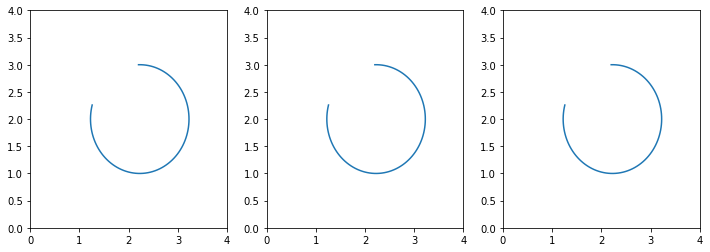

In [197]:
fig = plt.figure()
fig.set_figwidth(12)
#fig.set_figheight()

plt.subplot(1, 3, 1)

plt.plot(pos[:, 0, 0], pos[:, 1, 0])
plt.xlim((0., Lx))
plt.ylim((0., Ly))
#plt.axis('square')

plt.subplot(1, 3, 2)

plt.plot(pos[:, 0, 1], pos[:, 1, 1])
plt.xlim((0., Lx))
plt.ylim((0., Ly))
#plt.axis('square')

plt.subplot(1, 3, 3)

plt.plot(pos[:, 0, 2], pos[:, 1, 2])
plt.xlim((0., Lx))
plt.ylim((0., Ly))
#plt.axis('square')

# 3. Test accumulation

## 3. 1 Step 1

In [59]:
Nel       = [4, 6, 2]                 # mesh generation on logical domain
bc        = [False, False, False]     # boundary conditions (True: periodic, False: else)
p         = [2, 2, 1]                 # spline degrees 
nq_el     = [6, 6, 6]                 # number of quadrature points per element for integrations over whole domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)

# 1d B-spline finite element spaces
spaces = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)]

# 3d tensor-product B-spline spaces
tensor_space = spl.tensor_spline_space(spaces)


# number of basis functions in different spaces
NbaseN = tensor_space.NbaseN
NbaseD = tensor_space.NbaseD

Nbase_0form =  [NbaseN[0], NbaseN[1], NbaseN[2]]
Nbase_1form = [[NbaseD[0], NbaseN[1], NbaseN[2]], [NbaseN[0], NbaseD[1], NbaseN[2]], [NbaseN[0], NbaseN[1], NbaseD[2]]]
Nbase_2form = [[NbaseN[0], NbaseD[1], NbaseD[2]], [NbaseD[0], NbaseN[1], NbaseD[2]], [NbaseD[0], NbaseD[1], NbaseN[2]]]
Nbase_3form =  [NbaseD[0], NbaseD[1], NbaseD[2]]

Ntot_0form  =  NbaseN[0]*NbaseN[1]*NbaseN[2] 
Ntot_1form  = [NbaseD[0]*NbaseN[1]*NbaseN[2], NbaseN[0]*NbaseD[1]*NbaseN[2], NbaseN[0]*NbaseN[1]*NbaseD[2]]
Ntot_2form  = [NbaseN[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseD[1]*NbaseN[2]]  
Ntot_3form  =  NbaseD[0]*NbaseD[1]*NbaseD[2]


N = [bspline.Bspline(T, p)     for T, p in zip(T, p)]
D = [bspline.Bspline(t, p - 1) for t, p in zip(t, p)]

# geometry
kind_map   = 3
#params_map = [1., 1., 1.]
params_map = [2., 3., 0.01, 5.]

Np        = int(20)
particles = np.asfortranarray(np.random.rand(Np, 7))

B      = np.asfortranarray(np.random.rand(Np, 3))
B_prod = np.zeros((3, 3), dtype=float)
ginv   = np.zeros((3, 3), dtype=float)

acc = pic_accumu.accumulation(tensor_space)

mat12 = np.zeros((NbaseD[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseD[1], NbaseN[2]), dtype=float, order='F')
mat13 = np.zeros((NbaseD[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseD[2]), dtype=float, order='F')
mat23 = np.zeros((NbaseN[0], NbaseD[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseD[2]), dtype=float, order='F')

In [60]:
component = [[11, 12, 13],
             [21, 22, 23],
             [31, 32, 33]]


for ip in range(Np):
    
    print(ip)
    
    B_prod[0, 1] = -B[ip, 2]
    B_prod[0, 2] =  B[ip, 1]
    
    B_prod[1, 0] =  B[ip, 2]
    B_prod[1, 2] = -B[ip, 0]
    
    B_prod[2, 0] = -B[ip, 1]
    B_prod[2, 1] =  B[ip, 0]
    
    for i in range(3):
        for j in range(3):
            
            ginv[i, j] = mapping.g_inv(particles[ip, 0], particles[ip, 1], particles[ip, 2], kind_map, params_map, component[i][j])
            
            
    m = ginv.dot(B_prod.dot(ginv))
    
    
    # evaluation of 12 - block (DNN NDN)
    for i1 in range(NbaseD[0] + bc[0]*(p[0] - 1)):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):
                
                for j1 in range(NbaseN[0] + bc[0]*p[0]):
                    for j2 in range(NbaseD[1] + bc[1]*(p[1] - 1)):
                        for j3 in range(NbaseN[2] + bc[2]*p[2]):

                            D1i = D[0](particles[ip, 0], i1)*p[0]/(t[0][i1 + p[0]] - t[0][i1])
                            N2i = N[1](particles[ip, 1], i2)
                            N3i = N[2](particles[ip, 2], i3)
                            
                            N1j = N[0](particles[ip, 0], j1)
                            D2j = D[1](particles[ip, 1], j2)*p[1]/(t[1][j2 + p[1]] - t[1][j2])
                            N3j = N[2](particles[ip, 2], j3)

                            mat12[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseN[2], j1%NbaseN[0], j2%NbaseD[1], j3%NbaseN[2]] += D1i * N2i * N3i * N1j * D2j * N3j * m[0, 1] * particles[ip, 6]
                           
               
                
    # evaluation of 13 - component (DNN NND)
    for i1 in range(NbaseD[0] + bc[0]*(p[0] - 1)):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):
                
                for j1 in range(NbaseN[0] + bc[0]*p[0]):
                    for j2 in range(NbaseN[1] + bc[1]*p[1]):
                        for j3 in range(NbaseD[2] + bc[2]*(p[2] - 1)):
                
                            D1i = D[0](particles[ip, 0], i1)*p[0]/(t[0][i1 + p[0]] - t[0][i1])
                            N2i = N[1](particles[ip, 1], i2)
                            N3i = N[2](particles[ip, 2], i3)
                            
                            N1j = N[0](particles[ip, 0], j1)
                            N2j = N[1](particles[ip, 1], j2)
                            D3j = D[2](particles[ip, 2], j3)*p[2]/(t[2][j3 + p[2]] - t[2][j3])

                            mat13[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseN[2], j1%NbaseN[0], j2%NbaseN[1], j3%NbaseD[2]] += D1i * N2i * N3i * N1j * N2j * D3j * m[0, 2] * particles[ip, 6]
                
                
    # evaluation of 23 - component (NDN NND)
    for i1 in range(NbaseN[0] + bc[0]*p[0]):
        for i2 in range(NbaseD[1] + bc[1]*(p[1] - 1)):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):
                
                 for j1 in range(NbaseN[0] + bc[0]*p[0]):
                    for j2 in range(NbaseN[1] + bc[1]*p[1]):
                        for j3 in range(NbaseD[2] + bc[2]*(p[2] - 1)):
                
                            N1i = N[0](particles[ip, 0], i1)
                            D2i = D[1](particles[ip, 1], i2)*p[1]/(t[1][i2 + p[1]] - t[1][i2])
                            N3i = N[2](particles[ip, 2], i3)
                            
                            N1j = N[0](particles[ip, 0], j1)
                            N2j = N[1](particles[ip, 1], j2)
                            D3j = D[2](particles[ip, 2], j3)*p[2]/(t[2][j3 + p[2]] - t[2][j3])
                            
                            mat23[i1%NbaseN[0], i2%NbaseD[1], i3%NbaseN[2], j1%NbaseN[0], j2%NbaseN[1], j3%NbaseD[2]] += N1i * D2i * N3i * N1j * N2j * D3j * m[1, 2] * particles[ip, 6]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [61]:
mat_test = np.block([[np.zeros((Ntot_1form[0], Ntot_1form[0])), mat12.reshape(Ntot_1form[0], Ntot_1form[1]), mat13.reshape(Ntot_1form[0], Ntot_1form[2])], [-mat12.reshape(Ntot_1form[0], Ntot_1form[1]).T, np.zeros((Ntot_1form[1], Ntot_1form[1])), mat23.reshape(Ntot_1form[1], Ntot_1form[2])], [-mat13.reshape(Ntot_1form[0], Ntot_1form[2]).T, -mat23.reshape(Ntot_1form[1], Ntot_1form[2]).T, np.zeros((Ntot_1form[2], Ntot_1form[2]))]])

In [62]:
mat = acc.accumulation_step1(particles, B, kind_map, params_map)

In [63]:
np.allclose(mat_test, mat.toarray())

True

In [64]:
mat

<342x342 sparse matrix of type '<class 'numpy.float64'>'
	with 9216 stored elements in Compressed Sparse Column format>

## 3. 2 Step 3

In [2]:
Nel       = [24, 8, 4]                # mesh generation on logical domain
bc        = [True, True, True]     # boundary conditions (True: periodic, False: else)
p         = [3, 3, 2]                 # spline degrees  


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]

N         = [bspline.Bspline(T, p)     for T, p in zip(T, p)]
D         = [bspline.Bspline(t, p - 1) for t, p in zip(t, p)]

L = [3., 1.5, 2.]

DF     = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])
DFinv  = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])

G      = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])
Ginv   = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])

g_sqrt = L[0]*L[1]*L[2]

Np        = int(20)
particles = np.asfortranarray(np.random.rand(Np, 7))

Ntot = Nel[0]*Nel[1]*Nel[2]

In [3]:
B      = np.asfortranarray(np.random.rand(Np, 3))
B_prod = np.zeros((3, 3), dtype=float)

mat1  = np.zeros((NbaseD[0], NbaseN[1], NbaseN[2], 3*Np), dtype=float, order='F')
mat2  = np.zeros((NbaseN[0], NbaseD[1], NbaseN[2], 3*Np), dtype=float, order='F')
mat3  = np.zeros((NbaseN[0], NbaseN[1], NbaseD[2], 3*Np), dtype=float, order='F')

In [4]:
for ip in range(Np):
    
    B_prod[0, 1] = -B[ip, 2]
    B_prod[0, 2] =  B[ip, 1]
    
    B_prod[1, 0] =  B[ip, 2]
    B_prod[1, 2] = -B[ip, 0]
    
    B_prod[2, 0] = -B[ip, 1]
    B_prod[2, 1] =  B[ip, 0]
    
    mat = Ginv.dot(B_prod.dot(DFinv))
    
    # evaluation of 1 - component (DNN)
    for i1 in range(NbaseD[0] + bc[0]*(p[0] - 1)):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):

                D1 = D[0](particles[ip, 0], i1)*p[0]/(t[0][i1 + p[0]] - t[0][i1])
                N2 = N[1](particles[ip, 1], i2)
                N3 = N[2](particles[ip, 2], i3)

                mat1[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseN[2], ip + 0*Np] += D1 * N2 * N3 * mat[0, 0]
                mat1[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseN[2], ip + 1*Np] += D1 * N2 * N3 * mat[0, 1]
                mat1[i1%NbaseD[0], i2%NbaseN[1], i3%NbaseN[2], ip + 2*Np] += D1 * N2 * N3 * mat[0, 2]
               
                
    # evaluation of 2 - component (NDN)
    for i1 in range(NbaseN[0] + bc[0]*p[0]):
        for i2 in range(NbaseD[1] + bc[1]*(p[1] - 1)):
            for i3 in range(NbaseN[2] + bc[2]*p[2]):
                
                N1 = N[0](particles[ip, 0], i1)
                D2 = D[1](particles[ip, 1], i2)*p[1]/(t[1][i2 + p[1]] - t[1][i2])
                N3 = N[2](particles[ip, 2], i3)

                mat2[i1%NbaseN[0], i2%NbaseD[1], i3%NbaseN[2], ip + 0*Np] += N1 * D2 * N3 * mat[1, 0]
                mat2[i1%NbaseN[0], i2%NbaseD[1], i3%NbaseN[2], ip + 1*Np] += N1 * D2 * N3 * mat[1, 1]
                mat2[i1%NbaseN[0], i2%NbaseD[1], i3%NbaseN[2], ip + 2*Np] += N1 * D2 * N3 * mat[1, 2]
                
                
    # evaluation of 3 - component (NND)
    for i1 in range(NbaseN[0] + bc[0]*p[0]):
        for i2 in range(NbaseN[1] + bc[1]*p[1]):
            for i3 in range(NbaseD[2] + bc[2]*(p[2] - 1)):
                
                N1 = N[0](particles[ip, 0], i1)
                N2 = N[1](particles[ip, 1], i2)
                D3 = D[2](particles[ip, 2], i3)*p[2]/(t[2][i3 + p[2]] - t[2][i3])

                mat3[i1%NbaseN[0], i2%NbaseN[1], i3%NbaseD[2], ip + 0*Np] += N1 * N2 * D3 * mat[2, 0]
                mat3[i1%NbaseN[0], i2%NbaseN[1], i3%NbaseD[2], ip + 1*Np] += N1 * N2 * D3 * mat[2, 1]
                mat3[i1%NbaseN[0], i2%NbaseN[1], i3%NbaseD[2], ip + 2*Np] += N1 * N2 * D3 * mat[2, 2]
                
                
J14 = np.vstack((mat1.reshape(NbaseD[0]*NbaseN[1]*NbaseN[2], 3*Np), mat2.reshape(NbaseN[0]*NbaseD[1]*NbaseN[2], 3*Np), mat3.reshape(NbaseN[0]*NbaseN[1]*NbaseD[2], 3*Np)))
W = np.diag(np.concatenate((particles[:, 6], particles[:, 6], particles[:, 6])))
V = np.concatenate((particles[:, 3], particles[:, 4], particles[:, 5]))
res = J14.dot(W).dot(V)

In [ ]:
acc = accumu.accumulation(T, p, bc)
Rs, vec = acc.accumulation_step3(particles, B, 1, L)

In [25]:
np.allclose(vec, res)

True

In [26]:
test = J14.dot(W).dot(J14.T)

In [27]:
np.allclose(test, Rs.toarray())

True

In [13]:
np.save('hello', Rs.toarray())

In [14]:
h = np.load('hello.npy')